# Project: China Scientific Leadership

**Notebook:** Fig1_ab_China_Scientific_Leadership.ipynb

**Authors:** Renli Wu, Christopher Esposito, James Evans

**Affiliations:** School of Information Management, Wuhan University / Knowledge Lab, University of Chicago / University of California, Los Angeles

**Date:** 2024-11-29 (UTC)
**Version:** v0.3.0


**Purpose:**
This notebook generates **Figure 1a** and **Figure 1b** for the main text, and can also be used to generate **Figure S29** in the SI.

**Inputs:**
- `data/OpenAlex2023_Paper_Author_Lead_Pro_dataset.csv.gz` (preprocessed dataset with author–paper leadership roles)

**Outputs:**
- `pics/fig_1_a.svg`
- `pics/fig_1_b.svg`

**Notes:**
See `README.md` for details on environment setup, dependencies, and execution order within the full analysis pipeline.

In [1]:
import numpy as np
import pandas as pd
import time

### Load the leadership dataset

In [2]:
%%time
print(time.strftime('%l:%M%p %Z on %b %d, %Y'))
data = pd.read_csv("./data/OpenAlex2023_Paper_Author_Lead_Pro_dataset.csv.gz", compression="gzip")
print(time.strftime('%l:%M%p %Z on %b %d, %Y'), data.shape)
data.head()

 4:38AM CDT on Sep 17, 2025


<timed exec>:2: DtypeWarning: Columns (9,14,15) have mixed types. Specify dtype option on import or set low_memory=False.


 4:40AM CDT on Sep 17, 2025 (42995311, 22)
CPU times: user 2min 1s, sys: 10.4 s, total: 2min 11s
Wall time: 2min 12s


,paperId,authorId,publication_year,Lead_Pro,region,China_US,China_EU+,China_UK,US_EU+,UK_EU+,...,China_BeltRoad_HighIncome,China_BeltRoad_LowIncome,US_BeltRoad_HighIncome,US_BeltRoad_LowIncome,jif_2021,jif_mid,11_technical_area,fos_6,Honorary_authors,Matched_in_WOS
0,W3135965258,A5021665664,2021,0.155624,East Asia,False,False,False,False,False,...,False,False,NaN,NaN,1-5,3.0,DIS;EG;HPC;MAT;SC,earth & life science;chemistry & materials sci...,False,True
1,W3135965258,A5032223512,2021,0.263628,East Asia,False,False,False,False,False,...,False,False,NaN,NaN,1-5,3.0,DIS;EG;HPC;MAT;SC,earth & life science;chemistry & materials sci...,False,True
2,W3135978430,A5058653785,2021,0.300942,EU+,False,False,False,False,False,...,False,False,NaN,NaN,5-10,7.5,DIS;EG;MAT,mathematics & physics & engineering;chemistry ...,False,True
3,W3135978430,A5062473161,2021,0.689903,EU+,False,False,False,False,False,...,False,False,NaN,NaN,5-10,7.5,DIS;EG;MAT,mathematics & physics & engineering;chemistry ...,False,True
4,W3135978430,A5006524513,2021,0.242909,Latin America,False,False,False,False,False,...,False,False,NaN,NaN,5-10,7.5,DIS;EG;MAT,mathematics & physics & engineering;chemistry ...,False,True


### Main Text — China–US Relations in 2010–2012 and 2021–2023

In [3]:
import matplotlib.pyplot as plt
from matplotlib import ticker
from scipy.interpolate import make_interp_spline

In [4]:
# ---------- Config ----------
hue_colors = {"U.S.": "#006494", "U.K.": "#fdc086", "EU+": "#1b9e77", "China": "#C1224F"}
pair =  ("China", "U.S.")
# >>> Analytical focus: this tuple specifies the pair of regions under direct comparison.
# Altering it (e.g., to ("U.S.", "U.K."), ("China", "U.K.")) enables examination of alternative dyadic
# relationships and their dynamics. For reproducibility, however, the present figure
# should retain the originally reported pair.

year_windows = [(2010, 2012), (2019, 2021)]
nbins = 20
bin_edges = np.linspace(0, 1, nbins + 1)

In [5]:
# ---------- Helpers ----------
def kfmt(x, _pos):
    """Format y-axis with k for thousands."""
    if x >= 1000:
        r = np.round(x / 1000, 1)
        return f'{int(r)}k' if r == int(r) else f'{r}k'
    return str(int(x))

def _interval_mid(iv: pd.Interval) -> float:
    return float(iv.mid)

def _smooth_line(x, y, n=500):
    """Cubic spline where feasible"""
    x = np.asarray(x); y = np.asarray(y)
    xu, idx = np.unique(x, return_index=True)
    yu = y[idx]
    if xu.size >= 4:
        xs = np.linspace(xu.min(), xu.max(), n)
        ys = make_interp_spline(xu, yu, k=3)(xs)
        return xs, np.where(ys < 0, 0, ys)
    order = np.argsort(xu)
    return xu[order], np.where(yu[order] < 0, 0, yu[order])

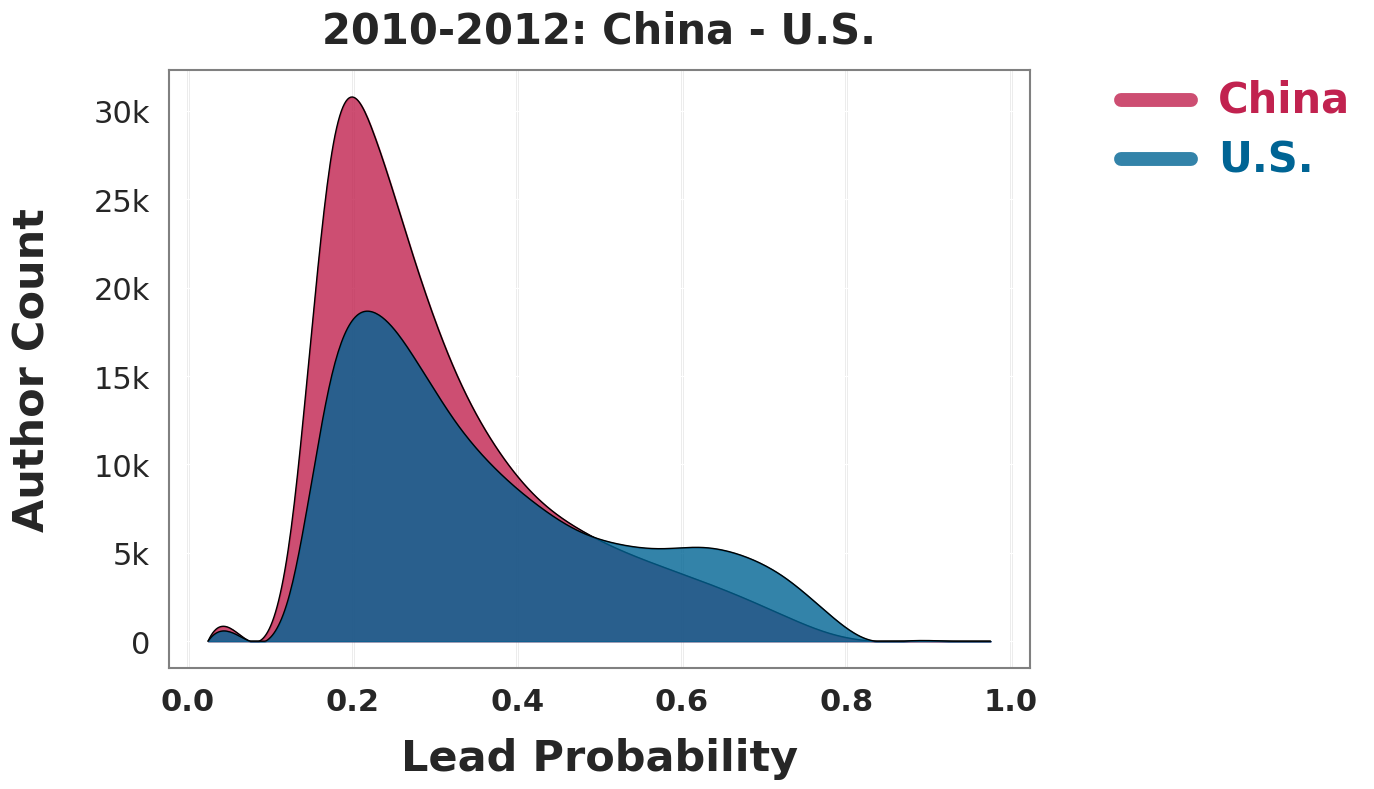

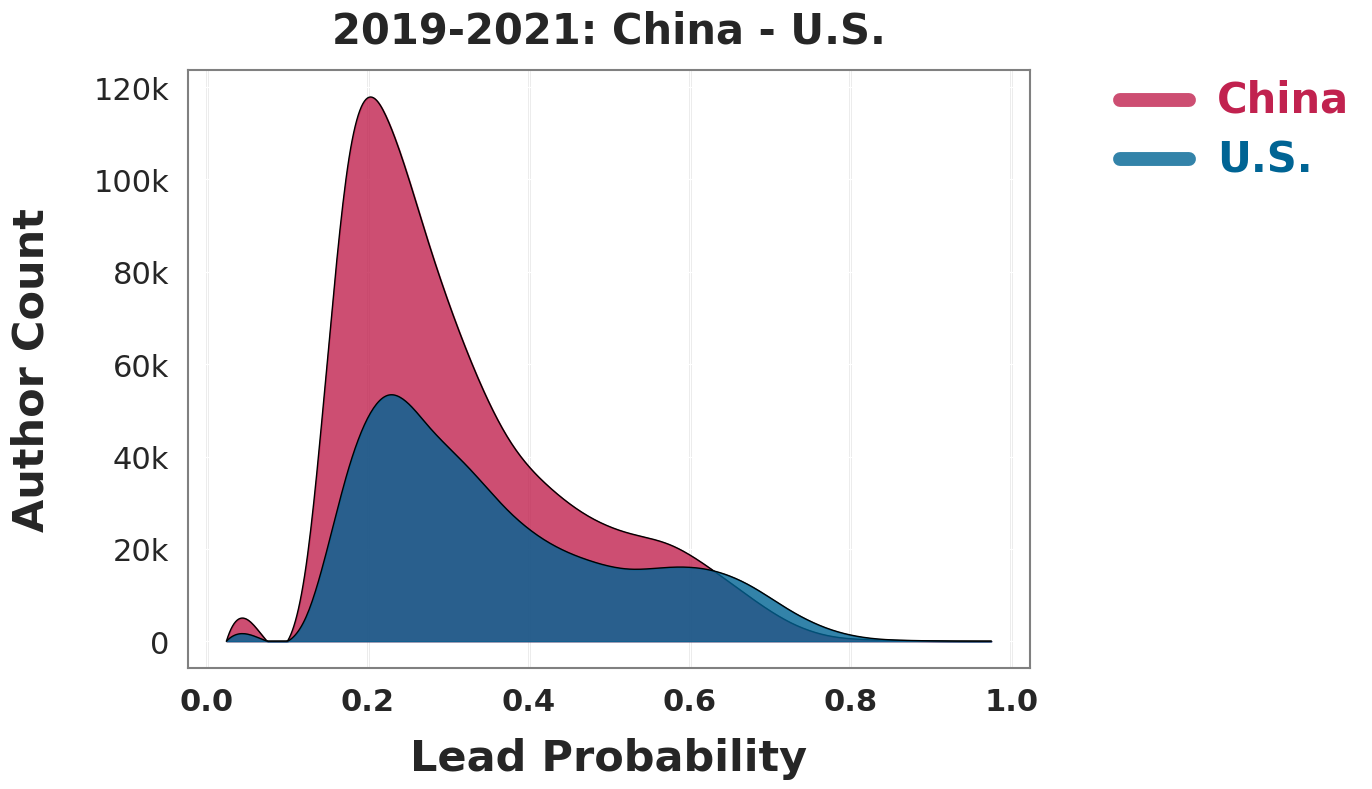

In [6]:
# ---------- Main ----------
for (st_year, end_year), ab in zip(year_windows, ["a", "b"]):
    c1, c2 = pair
    col_name = f"{c1.replace('.', '')}_{c2.replace('.', '')}"
    obs_df = (data.loc[(data[col_name] == True) & (data["publication_year"].between(st_year, end_year))
        , ["paperId", "authorId", "Lead_Pro", "region"]]
        .drop_duplicates(["paperId", "authorId", "region"])
        .copy())
    obs_df["val_bins"] = pd.cut(obs_df["Lead_Pro"], bins=bin_edges, include_lowest=True)

    # Count per region × bin midpoint
    obs_df["region"] = pd.Categorical(obs_df["region"], categories=[c1, c2])

    sta = (
    obs_df.groupby(["region", "val_bins"], observed=False)
    .size().rename("count").reset_index())
    sta["val_midpoints"] = sta["val_bins"].apply(_interval_mid).astype(float)

    sta_pair = (
        sta.pivot(index="val_midpoints", columns="region", values="count")
        .reindex(columns=[c1, c2]).fillna(0.0)
        .reset_index()
        .sort_values("val_midpoints")
    )

    # ---- Plot ----
    fig, ax = plt.subplots(figsize=(14, 8))
    for idx, region in enumerate((c1, c2)):
        if region not in sta_pair.columns:
            continue
        x = sta_pair["val_midpoints"].values
        y = sta_pair[region].values
        xs, ys = _smooth_line(x, y, n=500)

        color = hue_colors.get(region, "green")
        ax.plot(xs, ys, linestyle="-", linewidth=0.1, color=color, alpha=0.8, label=region, zorder=2+idx)
        ax.plot(xs, ys, linestyle="-", linewidth=1.0, color="black", zorder=3+idx)
        ax.fill_between(xs, ys, color=color, alpha=0.8, zorder=2+idx)

    # Axes cosmetics
    ax.xaxis.set_tick_params(pad=10)
    ax.yaxis.set_tick_params(pad=10)
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(kfmt))

    for t in ax.get_xticklabels():
        t.set_fontweight("bold"); t.set_fontsize(22)
    for t in ax.get_yticklabels():
        t.set_fontsize(22)

    ax.set_ylabel("Author Count", fontsize=31, fontweight="bold", labelpad=30)
    ax.set_xlabel("Lead Probability", fontsize=31, fontweight="bold", labelpad=15)

    # Legend outside
    leg = ax.legend(loc="center left", bbox_to_anchor=(1.07, 0.9), frameon=False,
                    prop={"size": 25, "weight": "bold"})
    for line, text in zip(leg.get_lines(), leg.get_texts()):
        line.set_linewidth(10)
        text.set_color(line.get_color())
        text.set_fontsize(30)
        text.set_fontweight("bold")

    # Gridlines
    for xv in np.arange(0, 1.01, 0.2):
        ax.axvline(x=xv, linestyle="-", linewidth=1, color="grey", alpha=0.8, zorder=-1)
    for spine in ax.spines.values():
        spine.set_edgecolor("grey"); spine.set_linewidth(1.5)
    ax.patch.set_visible(False)

    plt.title(f"{st_year}-{end_year}: {c1} - {c2}", pad=20, fontsize=30, fontweight="bold")
    plt.tight_layout()
    plt.savefig("./pics/" + f'fig_1_{ab}.svg', facecolor='white', bbox_inches='tight', format="svg")
    plt.show()